<h3 align=center> In His Name, the Most High </h3>

In [49]:
#importing libraries
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [50]:
def readIOB(filename, drop_list):
  words_list = list() # a list of list of words for every sentence in dataset
  tags_list = list() # a list of list of IOB tags for every sentence in dataset
  intents_list = list() # a list of intent for every sentence in dataset
  data = list() # a list of dicts contaiting above data in a more structured form
  vocabs = set() # a set containing whole dataset words

  with open(filename) as f:
    for line in f.readlines():
        line = line.strip().split()
        
        index = 0
        words = list()
        for i, word in enumerate(line[:-1]):
            if (word == 'EOS'):
                index = i
                break
            if (word != 'BOS'): 
                # word = re.sub(r'[^\w\s]', '', word) # removing punctuations
                word = re.sub(r"[?|'|!|.]","", word) # removing punctuations
                word = word.lower() # lowerizing word
                words.append(word) 
                vocabs.add(word)
        
        tags = list()
        for tag in line[index:-1]:
            tags.append(tag)
                    
        # handling entries with multiple intents
        intent = ""
        if ('#' in line[-1]): 
            for item in line[-1].split('#'):
                intent = item
                break
        else: intent = line[-1]

        if (intent not in drop_list): #dropping 
          words_list.append(words)
          tags_list.append(tags)
          intents_list.append(intent)
          data.append({
              # 'sentence': ' '.join(words),
              'words': words,
              'iob_tags': tags,
              'length': len(words),
              'intent': intent})
          

  word_dict = {'UNK': 0, 'PAD': 1}
  for i, item in enumerate(sorted(vocabs)):
    word_dict[item] = i + 2

  tags = set()
  for item in tags_list:
    for tag in item:
      tags.add(tag)
  slot_dict = dict()
  for i, item in enumerate(sorted(tags)):
    slot_dict[item] = i

  intent_dict = dict()
  for i, item in enumerate(sorted(set(intents_list))):
    intent_dict[item] = i

  return intent_dict, slot_dict, word_dict, words_list, tags_list, intents_list, sorted(vocabs), data


def dataStatistics(tags_list, intents_list, vocabs):
  print('dataset vocab size:', len(vocabs))
  print('# of dataset rows:', len(intents_list))
  print('# of dataset unique intents:', len(set(intents_list)))
  print('# of dataset unique IOB tags:', len(set([tag for item in tags_list for tag in item])))

  print('-' * 35 + '\nintents distribution:') 
  intents_freq = dict()
  for intent in set(intents_list):
      intents_freq[intent] = intents_list.count(intent)
  for key in intents_freq:
      value = intents_freq[key]
      print('%s: %d (%.2f%%),' % (key, value, value / len(intents_list) * 100))
  print()
  plt.figure(figsize=(24, 8))
  plt.bar(list(intents_freq.keys()),intents_freq.values())
  plt.show()

  print('\n' + '-' * 35 + '\ntags distribution:')
  tags_freq = dict()
  count = 0
  for item in tags_list:
      for tag in item:
          if (tag in tags_freq): tags_freq[tag] += 1 
          else: tags_freq[tag] = 1
          count += 1
  for key in tags_freq:
      value = tags_freq[key]
      print('%s: %d (%.2f%%),' % (key, value, value / count * 100))
    
  return intents_freq, tags_freq

In [51]:
drop_list = ['atis_cheapest', 'atis_city', 'atis_restriction', 'atis_meal', 'atis_distance', 'atis_airport', 'atis_capacity', 'atis_ground_fare','atis_flight_no']

dataset vocab size: 1000
# of dataset rows: 4770
# of dataset unique intents: 8
# of dataset unique IOB tags: 120
-----------------------------------
intents distribution:
atis_airfare: 874 (18.32%),
atis_airline: 293 (6.14%),
atis_flight_time: 112 (2.35%),
atis_quantity: 100 (2.10%),
atis_abbreviation: 152 (3.19%),
atis_ground_service: 524 (10.99%),
atis_aircraft: 161 (3.38%),
atis_flight: 2554 (53.54%),



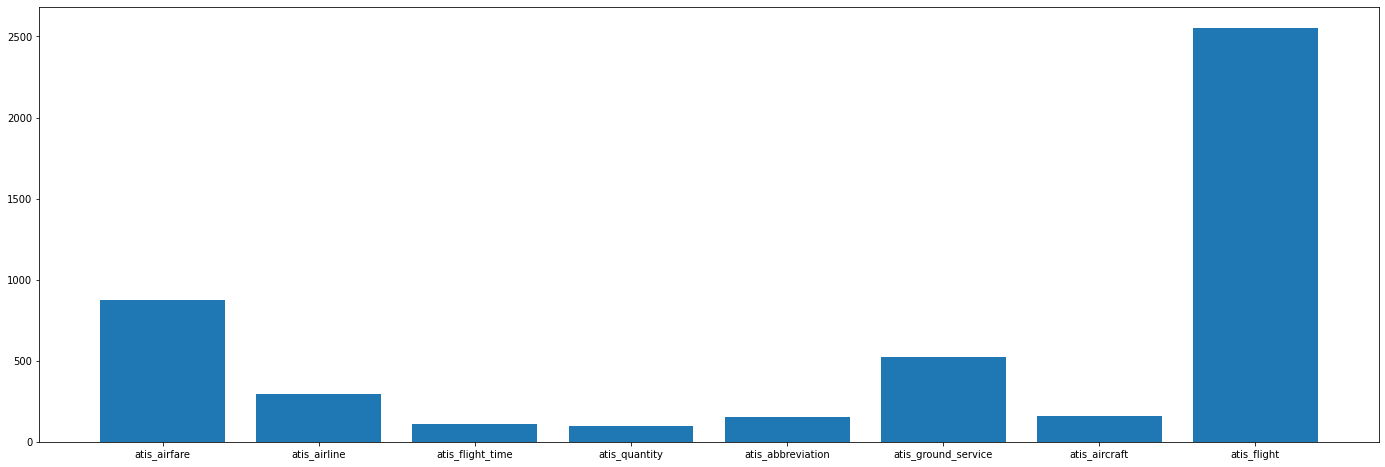


-----------------------------------
tags distribution:
EOS: 4770 (8.07%),
O: 34467 (58.31%),
B-transport_type: 60 (0.10%),
I-transport_type: 29 (0.05%),
B-city_name: 395 (0.67%),
B-airport_name: 50 (0.08%),
I-airport_name: 63 (0.11%),
B-airline_name: 680 (1.15%),
B-fromloc.city_name: 3952 (6.69%),
B-toloc.city_name: 3958 (6.70%),
I-toloc.city_name: 1041 (1.76%),
B-aircraft_code: 22 (0.04%),
B-cost_relative: 455 (0.77%),
B-round_trip: 486 (0.82%),
I-round_trip: 496 (0.84%),
B-fare_basis_code: 79 (0.13%),
I-fare_basis_code: 2 (0.00%),
I-airline_name: 402 (0.68%),
I-fromloc.city_name: 602 (1.02%),
B-depart_date.day_name: 716 (1.21%),
B-depart_time.period_of_day: 521 (0.88%),
B-airline_code: 146 (0.25%),
B-flight_number: 123 (0.21%),
B-depart_time.time_relative: 289 (0.49%),
B-depart_time.time: 336 (0.57%),
B-meal_description: 42 (0.07%),
B-class_type: 320 (0.54%),
I-class_type: 273 (0.46%),
B-depart_date.today_relative: 80 (0.14%),
I-city_name: 93 (0.16%),
B-depart_date.month_name: 387 (

In [52]:
#importing train data
train_intent_dict, train_tag_dict, train_word_dict, train_words, train_tags, train_intents, train_vocabs, train_data = readIOB('atis-train-final-w-intent.iob', drop_list = drop_list)
train_intents_freq, train_tags_freq = dataStatistics(train_tags, train_intents, train_vocabs)

dataset vocab size: 412
# of dataset rows: 816
# of dataset unique intents: 9
# of dataset unique IOB tags: 99
-----------------------------------
intents distribution:
atis_day_name: 2 (0.25%),
atis_airfare: 49 (6.00%),
atis_airline: 38 (4.66%),
atis_flight_time: 1 (0.12%),
atis_quantity: 3 (0.37%),
atis_abbreviation: 33 (4.04%),
atis_flight: 645 (79.04%),
atis_ground_service: 36 (4.41%),
atis_aircraft: 9 (1.10%),



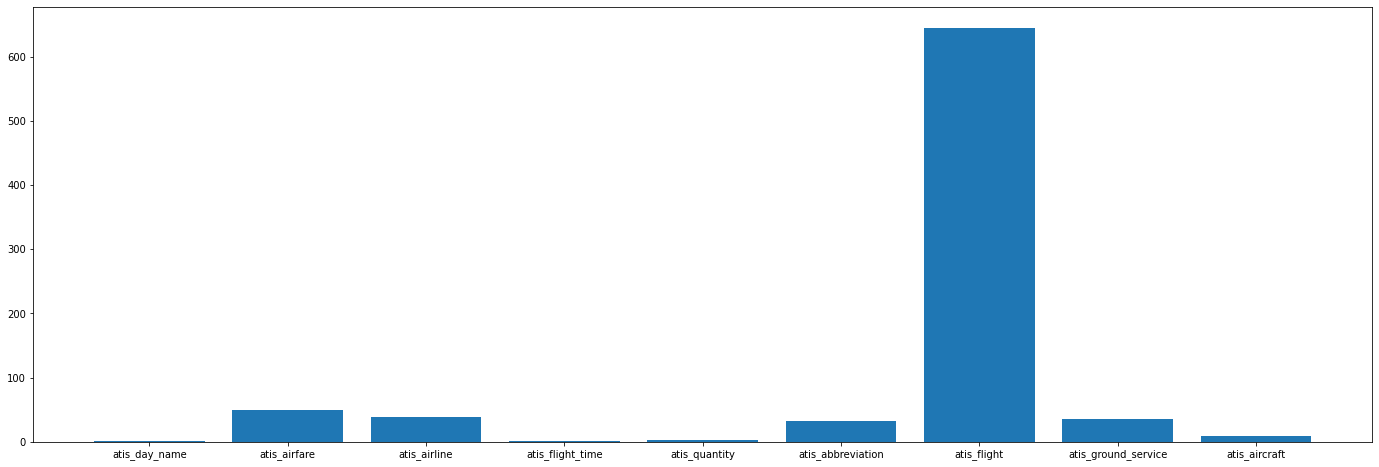


-----------------------------------
tags distribution:
EOS: 816 (8.74%),
O: 5044 (54.02%),
B-fromloc.city_name: 688 (7.37%),
B-toloc.city_name: 700 (7.50%),
I-toloc.city_name: 256 (2.74%),
B-stoploc.city_name: 20 (0.21%),
I-stoploc.city_name: 10 (0.11%),
B-depart_date.month_name: 56 (0.60%),
B-depart_date.day_number: 55 (0.59%),
B-depart_time.time_relative: 63 (0.67%),
B-depart_time.time: 55 (0.59%),
I-depart_time.time: 50 (0.54%),
B-round_trip: 73 (0.78%),
I-round_trip: 71 (0.76%),
B-airline_name: 87 (0.93%),
I-airline_name: 60 (0.64%),
B-depart_date.day_name: 209 (2.24%),
B-depart_time.period_of_day: 129 (1.38%),
I-fromloc.city_name: 176 (1.88%),
B-meal_description: 9 (0.10%),
B-depart_date.date_relative: 17 (0.18%),
B-arrive_time.time_relative: 31 (0.33%),
B-arrive_time.time: 33 (0.35%),
I-arrive_time.time: 34 (0.36%),
B-return_date.day_name: 2 (0.02%),
B-arrive_date.date_relative: 2 (0.02%),
B-arrive_date.day_name: 11 (0.12%),
B-flight_stop: 21 (0.22%),
B-depart_date.today_relativ

In [53]:
#importing test data
test_intent_dict, test_tag_dict, train_word_dict, test_words, test_tags, test_intents, test_vocabs, test_data = readIOB('atis-test-final-w-intent.iob', drop_list = drop_list)
test_intents_freq, test_tags_freq = dataStatistics(test_tags, test_intents, test_vocabs)

In [54]:
temp = set()
for tag in train_intent_dict:
  temp.add(tag)
for tag in test_intent_dict:
  temp.add(tag)
f = open('vocab.intents','w')
for item in sorted(temp):
  f.write(item + '\n')
f.close()

In [55]:
temp = set()
for tag in train_tag_dict:
  temp.add(tag)
for tag in test_tag_dict:
  temp.add(tag)
f = open('vocab.tags','w')
for item in sorted(temp):
  f.write(item + '\n')
f.close()

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_epoch = 50#500
max_len = 50
for item in train_data:
  if (item['length'] > max_len): max_len = item['length']
for item in test_data:
  if (item['length'] > max_len): max_len = item['length']

batch = 16
learning_rate = 0.001
DROPOUT = 0.2 # 0.2, 0.3, 0.4

embedding_size = 300
lstm_hidden_size = 200

In [57]:
# Make tag dict 
train_tag_dict = {}

with open('vocab.tags') as f:
    for i, line in enumerate(f.readlines()):
        train_tag_dict[line.strip()] = i

In [58]:
# Make intent dict 
train_intent_dict = {}

with open('vocab.intents') as f:
    for i, line in enumerate(f.readlines()):
        train_intent_dict[line.strip()] = i

In [59]:
index2slot_dict = {}
for key in train_tag_dict:
    index2slot_dict[train_tag_dict[key]] = key

# index2slot_dict[len(train_tag_dict)] = 'unk' #unknown?

In [60]:
def intent2index(intent, intent_dict=train_intent_dict):
  # if (intent in intent_dict.keys()): return intent_dict[intent]
  # else: return 'unk'
  return intent_dict[intent]

def tags2index(tags, tags_dict=train_tag_dict):
  tagsindex = list()
  for tag in tags:
    # if(tag in tags_dict.keys()): tagsindex.append(tags_dict[tag])
    # else: tagsindex.append(len(tags_dict)) #unknown?
    tagsindex.append(tags_dict[tag])
  
  while len(tagsindex) < max_len:
    tagsindex.append(tags_dict['O'])

  return tagsindex

def words2index(words, word_dict=train_word_dict):
  sentence = list()
  for word in words:
    if word in word_dict:
      sentence.append(word_dict[word])
    else:
      sentence.append(word_dict['UNK'])

  while len(sentence) < max_len:
    sentence.append(word_dict['PAD'])

  return sentence

def make_mask(real_len, max_len=max_len, label_size=len(train_tag_dict), batch=batch):
    mask = torch.zeros(batch, max_len, label_size)
    for index, item in enumerate(real_len):
        mask[index, :item, :] = 1.0
    return mask


def masked_log_softmax(vector: torch.Tensor, mask: torch.Tensor, dim: int = -1) -> torch.Tensor:
    if mask is not None:
        mask = mask.float()
        while mask.dim() < vector.dim():
            mask = mask.unsqueeze(1)
        
        vector = vector + (mask + 1e-45).log()
    return F.log_softmax(vector, dim=dim)


def one_hot(array, Num=len(train_tag_dict), maxlen=max_len):

    shape = array.size()
    batch = shape[0]
    if len(shape) == 1:
        res = torch.zeros(batch, Num)
        for i in range(batch):
            res[i][array[i]] = 1
    else:
        res = torch.zeros(batch, maxlen, Num)
        for i in range(batch):
            for j in range(maxlen):
                if array[i, j] == Num:
                    pass
                else:
                    res[i][j][array[i, j]] = 1

    return res


def get_batch(data, batch_size=batch):
    random.shuffle(data)
    sindex = 0
    eindex = batch_size
    while eindex < len(data):
        orig_sentence = []
        sentence = []
        real_len = []
        slot_label = []
        intent_label = []
         
        batch = data[sindex:eindex]
        for m in range(sindex, eindex):
            orig_sentence.append(' '.join(data[m]['words']))
            sentence.append(words2index(data[m]['words']))
            real_len.append(data[m]['length'])
            slot_label.append(tags2index(data[m]['iob_tags']))
            intent_label.append(intent2index(data[m]['intent']))

        temp = eindex
        eindex = eindex + batch_size
        sindex = temp

        yield (orig_sentence, sentence, real_len, slot_label, intent_label)

def get_chunks(labels):
    chunks = []
    start_idx,end_idx = 0,0
    for idx in range(1,len(labels)-1):
        chunkStart, chunkEnd = False,False
        if labels[idx-1] not in ('O', '<pad>', '<unk>', '<s>', '</s>', '<STOP>', '<START>'):
            prevTag, prevType = labels[idx-1][:1], labels[idx-1][2:]
        else:
            prevTag, prevType = 'O', 'O'
        if labels[idx] not in ('O', '<pad>', '<unk>', '<s>', '</s>', '<STOP>', '<START>'):
            Tag, Type = labels[idx][:1], labels[idx][2:]
        else:
            Tag, Type = 'O', 'O'
        if labels[idx+1] not in ('O', '<pad>', '<unk>', '<s>', '</s>', '<STOP>', '<START>'):
            nextTag, nextType = labels[idx+1][:1], labels[idx+1][2:]
        else:
            nextTag, nextType = 'O', 'O'

        if (Tag == 'B' and prevTag in ('B', 'I', 'O')) or (prevTag, Tag) in [('O', 'I'), ('E', 'E'), ('E', 'I'), ('O', 'E')]:
            chunkStart = True
        if Tag != 'O' and prevType != Type:
            chunkStart = True

        if (Tag in ('B','I') and nextTag in ('B','O')) or (Tag == 'E' and nextTag in ('E', 'I', 'O')):
            chunkEnd = True
        if Tag != 'O' and Type != nextType:
            chunkEnd = True

        if chunkStart:
            start_idx = idx
        if chunkEnd:
            end_idx = idx
            chunks.append((start_idx,end_idx,Type))
            start_idx,end_idx = 0,0
    return chunks

In [61]:
# Bi-model 
class slot_enc(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, vocab_size=len(train_word_dict)):
        super(slot_enc, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=lstm_hidden_size, num_layers=2,\
                            bidirectional= True, batch_first=True) #, dropout=DROPOUT)

    def forward(self, x):
        x = self.embedding(x)
        x = F.dropout(x, DROPOUT)       
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)
        return x 


class slot_dec(nn.Module):
    def __init__(self, lstm_hidden_size, label_size=len(train_tag_dict)):
        super(slot_dec, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_hidden_size*5, hidden_size=lstm_hidden_size, num_layers=1)
        self.fc = nn.Linear(lstm_hidden_size, label_size)
        self.hidden_size = lstm_hidden_size

    def forward(self, x, hi):
        batch = x.size(0)
        length = x.size(1)
        dec_init_out = torch.zeros(batch, 1, self.hidden_size).to(device)
        hidden_state = (torch.zeros(1, 1, self.hidden_size).to(device), \
                        torch.zeros(1, 1, self.hidden_size).to(device))
        x = torch.cat((x, hi), dim=-1)

        x = x.transpose(1, 0)  # 50 x batch x feature_size
        x = F.dropout(x, DROPOUT)
        all_out = []
        for i in range(length):
            if i == 0:
                out, hidden_state = self.lstm(torch.cat((x[i].unsqueeze(1), dec_init_out), dim=-1), hidden_state)
            else:
                out, hidden_state = self.lstm(torch.cat((x[i].unsqueeze(1), out), dim=-1), hidden_state)
            all_out.append(out)
        output = torch.cat(all_out, dim=1) # 50 x batch x feature_size
        x = F.dropout(x, DROPOUT)
        res = self.fc(output)
        return res 


class intent_enc(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, vocab_size=len(train_word_dict)):
        super(intent_enc, self).__init__()
		
        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        # self.embedding.weight.data.uniform_(-1.0, 1.0)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= lstm_hidden_size, num_layers=2,\
                            bidirectional= True, batch_first=True, dropout=DROPOUT)
    
    def forward(self, x):
        x = self.embedding(x)
        x = F.dropout(x, DROPOUT)
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)
        return x


class intent_dec(nn.Module):
    def __init__(self, lstm_hidden_size, label_size=len(train_intent_dict)):
        super(intent_dec, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_hidden_size*4, hidden_size=lstm_hidden_size, batch_first=True, num_layers=1)#, dropout=DROPOUT)
        self.fc = nn.Linear(lstm_hidden_size, label_size)
        
    def forward(self, x, hs, real_len):
        batch = x.size()[0]
        real_len = torch.tensor(real_len).to(device)
        x = torch.cat((x, hs), dim=-1)
        x = F.dropout(x, DROPOUT)
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)

        index = torch.arange(batch).long().to(device)
        state = x[index, real_len-1, :]
        
        res = self.fc(state.squeeze())
        return res
        


class Intent(nn.Module):
    def __init__(self):
        super(Intent, self).__init__()
        self.enc = intent_enc(embedding_size, lstm_hidden_size).to(device)
        self.dec = intent_dec(lstm_hidden_size).to(device)
        self.share_memory = torch.zeros(batch, max_len, lstm_hidden_size * 2).to(device)
    

class Slot(nn.Module):
    def __init__(self):
        super(Slot, self).__init__()
        self.enc = slot_enc(embedding_size, lstm_hidden_size).to(device)
        self.dec = slot_dec(lstm_hidden_size).to(device)
        self.share_memory = torch.zeros(batch, max_len, lstm_hidden_size * 2).to(device)

In [62]:
# Set the seed value all over the place to make this reproducible.
seed_val = 1

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [63]:
epoch_num = total_epoch

# load the entire model.
# intent_model = torch.load('model_intent_best.ckpt').to(device)
# slot_model = torch.load('model_slot_best.ckpt').to(device)
# slot_model = Slot().to(device)
# intent_model = Intent().to(device)

print(slot_model)
print(intent_model)

slot_optimizer = optim.Adam(slot_model.parameters(), lr=learning_rate)       # optim.Adamax
intent_optimizer = optim.Adam(intent_model.parameters(), lr=learning_rate)   # optim.Adamax

best_correct_num = 0
best_epoch = -1
best_F1_score = 0.0
best_epoch_slot = -1
for epoch in range(epoch_num):
    slot_loss_history = []
    intent_loss_history = []
    for batch_index, data in enumerate(get_batch(train_data)): 

	    # Preparing data
        _, sentence, real_len, slot_label, intent_label = data

        mask = make_mask(real_len).to(device)
        x = torch.tensor(sentence).to(device)
        y_slot = torch.tensor(slot_label).to(device)
        y_slot = one_hot(y_slot).to(device)
        y_intent = torch.tensor(intent_label).to(device)
        y_intent = one_hot(y_intent, Num=len(train_intent_dict)).to(device)

		# Calculate compute graph
        slot_optimizer.zero_grad()
        intent_optimizer.zero_grad()
		
        hs = slot_model.enc(x)
        slot_model.share_memory = hs.clone()

        hi = intent_model.enc(x)
        intent_model.share_memory = hi.clone()
		
		
        slot_logits = slot_model.dec(hs, intent_model.share_memory.detach())
        log_slot_logits = masked_log_softmax(slot_logits, mask, dim=-1)
        slot_loss = -1.0*torch.sum(y_slot*log_slot_logits)
        slot_loss_history.append(slot_loss.item())
        slot_loss.backward()
        torch.nn.utils.clip_grad_norm_(slot_model.parameters(), 5.0)
        slot_optimizer.step()

        # Asynchronous training
        intent_logits = intent_model.dec(hi, slot_model.share_memory.detach(), real_len)
        log_intent_logits = F.log_softmax(intent_logits, dim=-1)
        intent_loss = -1.0*torch.sum(y_intent*log_intent_logits)
        intent_loss_history.append(intent_loss.item())
        intent_loss.backward()
        torch.nn.utils.clip_grad_norm_(intent_model.parameters(), 5.0)
        intent_optimizer.step()
        
		# Log
        if batch_index % 100 == 0 and batch_index > 0:
            print('Slot loss: {:.4f} \t Intent loss: {:.4f}'.format(sum(slot_loss_history[-100:])/100.0, \
                sum(intent_loss_history[-100:])/100.0))

    # Evaluation 
    total_test = len(test_data)
    correct_num = 0
    TP, FP, FN = 0, 0, 0
    for batch_index, data_test in enumerate(get_batch(test_data, batch_size=1)):
        orig_sentence_test, sentence_test, real_len_test, slot_label_test, intent_label_test = data_test
        # print(sentence[0].shape, real_len.shape, slot_label.shape)
        x_test = torch.tensor(sentence_test).to(device)

        mask_test = make_mask(real_len_test, batch=1).to(device)
        # Slot model generate hs_test and intent model generate hi_test
        hs_test = slot_model.enc(x_test)
        hi_test = intent_model.enc(x_test)

        # Slot
        slot_logits_test = slot_model.dec(hs_test, hi_test)
        log_slot_logits_test = masked_log_softmax(slot_logits_test, mask_test, dim=-1)
        slot_pred_test = torch.argmax(log_slot_logits_test, dim=-1)
        # Intent
        intent_logits_test = intent_model.dec(hi_test, hs_test, real_len_test)
        log_intent_logits_test = F.log_softmax(intent_logits_test, dim=-1)
        res_test = torch.argmax(log_intent_logits_test, dim=-1)
        

        if res_test.item() == intent_label_test[0]:
            correct_num += 1
        if correct_num > best_correct_num:
            best_correct_num = correct_num
            best_epoch = epoch
			# Save and load the entire model.
            # torch.save(intent_model, 'model_intent_best.ckpt')
            # torch.save(slot_model, 'model_slot_best.ckpt')
    
        # Calc slot F1 score
        # print(slot_pred_test)
        # print(slot_label_test)
        slot_pred_test = slot_pred_test[0][:real_len_test[0]]
        slot_label_test = slot_label_test[0][:real_len_test[0]]

        slot_pred_test = [int(item) for item in slot_pred_test]
        slot_label_test = [int(item) for item in slot_label_test]

        slot_pred_test = [index2slot_dict[item] for item in slot_pred_test]
        slot_label_test = [index2slot_dict[item] for item in slot_label_test]
        
        pred_chunks = get_chunks(['O'] + slot_pred_test + ['O']) 
        label_chunks = get_chunks(['O'] + slot_label_test + ['O'])

        # print(orig_sentence_test)
        # print(slot_pred_test)
        # print(slot_label_test)
        # print('pred')
        # print(pred_chunks)
        # print('label')
        # print(label_chunks)
        # if(batch_index == 2): a

        for pred_chunk in pred_chunks:
            if pred_chunk in label_chunks:
                TP += 1
            else:
                FP += 1
        for label_chunk in label_chunks:
            if label_chunk not in pred_chunks:
                FN += 1

    F1_score = 100.0*2*TP/(2*TP+FN+FP)
    if F1_score > best_F1_score:
        best_F1_score = F1_score
        best_epoch_slot = epoch
    print('*' * 20)
    print('Epoch: [{}/{}], Intent Val Acc: {:.4f} \t Slot F1 score: {:.4f}'.format(epoch+1, epoch_num, 100.0*correct_num/total_test, F1_score))
    print('*' * 20)
    
    print('Best Intent Acc: {:.4f} at Epoch: [{}]'.format(100.0*best_correct_num/total_test, best_epoch+1))
    print('Best F1 score: {:.4f} at Epoch: [{}]'.format(best_F1_score, best_epoch_slot+1))

Slot(
  (enc): slot_enc(
    (embedding): Embedding(414, 300)
    (lstm): LSTM(300, 200, num_layers=2, batch_first=True, bidirectional=True)
  )
  (dec): slot_dec(
    (lstm): LSTM(1000, 200)
    (fc): Linear(in_features=200, out_features=126, bias=True)
  )
)
Intent(
  (enc): intent_enc(
    (embedding): Embedding(414, 300)
    (lstm): LSTM(300, 200, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (dec): intent_dec(
    (lstm): LSTM(800, 200, batch_first=True)
    (fc): Linear(in_features=200, out_features=9, bias=True)
  )
)
Slot loss: 1.0356 	 Intent loss: 0.0001
Slot loss: 2.1992 	 Intent loss: 0.0000
********************
Epoch: [1/5], Intent Val Acc: 98.4069 	 Slot F1 score: 91.1526
********************
Best Intent Acc: 98.4069 at Epoch: [1]
Best F1 score: 91.1526 at Epoch: [1]
Slot loss: 0.6650 	 Intent loss: 0.7132
Slot loss: 0.9677 	 Intent loss: 0.2262
********************
Epoch: [2/5], Intent Val Acc: 99.0196 	 Slot F1 score: 91.2321
*******************

In [64]:
# Save the entire model
torch.save(intent_model, 'model_intent_best.ckpt')
torch.save(slot_model, 'model_slot_best.ckpt')